## Model Evaluation & Explainability

In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import joblib
import lightgbm as lgb
import shap
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load tuned model
model = joblib.load('../../models/tuned/lightgbm_tuned_v1.pkl')

print(f"Model loaded: {type(model).__name__}")
print(f"Number of estimators: {model.n_estimators}")


Model loaded: LGBMClassifier
Number of estimators: 981


In [3]:
# Load Phase 5 data
X_train = pd.read_csv('../../data/processed/phase5_installments/X_train.csv')
X_val = pd.read_csv('../../data/processed/phase5_installments/X_val.csv')
X_test = pd.read_csv('../../data/processed/phase5_installments/X_test.csv')
y_train = pd.read_csv('../../data/processed/phase5_installments/y_train.csv')
y_val = pd.read_csv('../../data/processed/phase5_installments/y_val.csv')

# Drop ID columns
X_train = X_train.drop('SK_ID_CURR', axis=1)
X_val = X_val.drop('SK_ID_CURR', axis=1)
test_ids = X_test['SK_ID_CURR'].copy()
X_test = X_test.drop('SK_ID_CURR', axis=1)

# Convert target to 1D array
y_train = y_train['TARGET'].values
y_val = y_val['TARGET'].values

print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")
print(f"Features: {len(X_train.columns)}")


Train: (246008, 95)
Val: (61503, 95)
Test: (48744, 95)
Features: 95


### Performance Check


In [4]:
# Get predictions
y_train_pred = model.predict_proba(X_train)[:, 1]
y_val_pred = model.predict_proba(X_val)[:, 1]

# Calculate AUC
train_auc = roc_auc_score(y_train, y_train_pred)
val_auc = roc_auc_score(y_val, y_val_pred)

print(f"Baseline Performance:")
print(f"  Train AUC: {train_auc:.4f}")
print(f"  Val AUC:   {val_auc:.4f}")
print(f"  Difference: {train_auc - val_auc:.4f}")


Baseline Performance:
  Train AUC: 0.8223
  Val AUC:   0.7780
  Difference: 0.0443


### Feature Importance


In [9]:
importance_gain = model.feature_importances_

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance_gain
}).sort_values('importance', ascending=False)

print(f"Top 50 Features by Gain:")
print(feature_importance.head(50))


Top 50 Features by Gain:
                                feature  importance
8                          EXT_SOURCE_1         257
34                         EXT_SOURCE_3         221
29                           DAYS_BIRTH         217
48                           AMT_CREDIT         210
38                          AMT_ANNUITY         194
36                         EXT_SOURCE_2         168
60                      AMT_GOODS_PRICE         160
76       bureau_DAYS_CREDIT_ENDDATE_max         151
2                         DAYS_EMPLOYED         139
22       pos_CNT_INSTALMENT_FUTURE_mean         114
42          inst_inst_payment_delay_max         106
43               bureau_DAYS_CREDIT_max         106
28                 prev_app_credit_diff         104
62                      DAYS_ID_PUBLISH         104
21                 inst_AMT_PAYMENT_sum         101
90                   prev_approval_rate         101
23    prev_HOUR_APPR_PROCESS_START_mean          99
78            bureau_AMT_CREDIT_SUM_sum

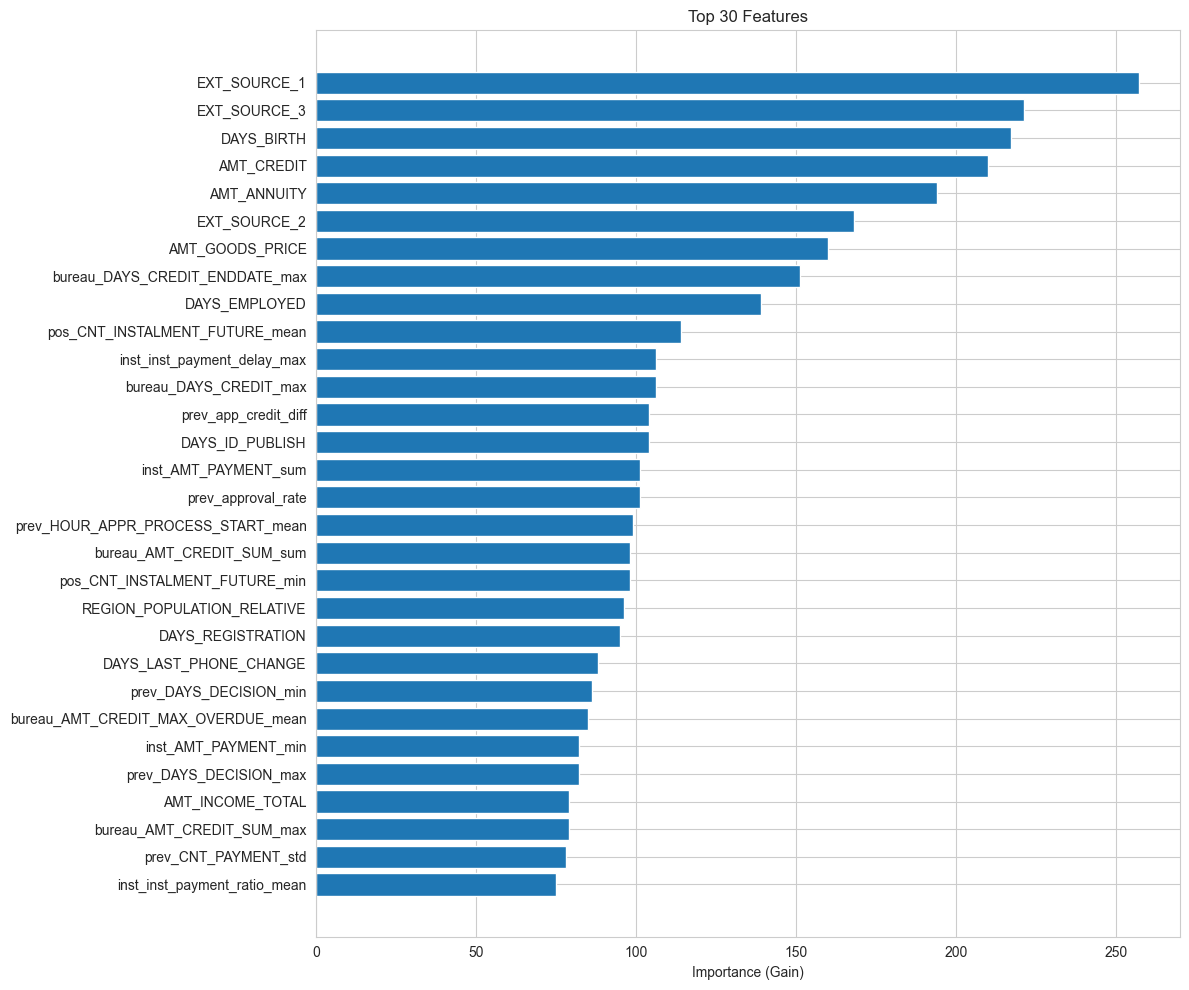

In [6]:
plt.figure(figsize=(12, 10))
top_30 = feature_importance.head(30)

plt.barh(range(len(top_30)), top_30['importance'].values)
plt.yticks(range(len(top_30)), top_30['feature'].values)
plt.gca().invert_yaxis()
plt.xlabel('Importance (Gain)')
plt.title('Top 30 Features')
plt.tight_layout()
plt.show()


In [50]:
# Save feature importance
Path('../../models/final').mkdir(parents=True, exist_ok=True)
feature_importance.to_csv('../../models/final/feature_importance.csv', index=False)
print("Feature importance saved")


Feature importance saved


### Progressive Feature Elimination


In [7]:
import time

# Test different feature counts
feature_counts = [80, 60, 50, 40, 30, 20, 15, 10]
results = []

# Baseline
results.append({
    'n_features': len(X_train.columns),
    'train_auc': train_auc,
    'val_auc': val_auc,
    'auc_drop': 0.0,
    'training_time': 0.0
})

print(f"Testing feature reduction...")
print(f"Baseline: {len(X_train.columns)} features, Val AUC: {val_auc:.4f}\n")

for n in feature_counts:
    if n >= len(X_train.columns):
        continue
    
    # Select top N features
    top_features = feature_importance.head(n)['feature'].values
    X_train_reduced = X_train[top_features]
    X_val_reduced = X_val[top_features]
    
    start_time = time.time()
    model_reduced = lgb.LGBMClassifier(
        #objective='binary',
        metric='auc',
        #is_unbalance=True,

        n_estimators= 981,
        learning_rate= 0.0701261784638505,
        max_depth=3,
        num_leaves=50,
        min_child_samples=77,
        subsample=0.5022449878003225,
        colsample_bytree=0.9670688728186712,
        reg_alpha=0.0005469072612312737,
        reg_lambda= 2.5536050141966927e-06
    )
    model_reduced.fit(X_train_reduced, y_train)
    training_time = time.time() - start_time
    
    # Evaluate
    y_train_pred_reduced = model_reduced.predict_proba(X_train_reduced)[:, 1]
    y_val_pred_reduced = model_reduced.predict_proba(X_val_reduced)[:, 1]
    
    train_auc_reduced = roc_auc_score(y_train, y_train_pred_reduced)
    val_auc_reduced = roc_auc_score(y_val, y_val_pred_reduced)
    auc_drop = val_auc - val_auc_reduced
    
    results.append({
        'n_features': n,
        'train_auc': train_auc_reduced,
        'val_auc': val_auc_reduced,
        'auc_drop': auc_drop,
        'training_time': training_time
    })
    
    print(f"{n:2d} features: Train AUC={train_auc_reduced:.4f}, Val AUC={val_auc_reduced:.4f}, "
          f"Drop={auc_drop:.4f}, Time={training_time:.1f}s")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\nFeature Reduction Results:")
print(results_df)


Testing feature reduction...
Baseline: 95 features, Val AUC: 0.7780

80 features: Train AUC=0.8197, Val AUC=0.7789, Drop=-0.0010, Time=9.9s
60 features: Train AUC=0.8181, Val AUC=0.7763, Drop=0.0016, Time=7.3s
50 features: Train AUC=0.8157, Val AUC=0.7754, Drop=0.0026, Time=6.3s
40 features: Train AUC=0.8140, Val AUC=0.7751, Drop=0.0029, Time=5.6s
30 features: Train AUC=0.8102, Val AUC=0.7723, Drop=0.0057, Time=5.0s
20 features: Train AUC=0.8026, Val AUC=0.7696, Drop=0.0083, Time=3.7s
15 features: Train AUC=0.7969, Val AUC=0.7651, Drop=0.0129, Time=2.9s
10 features: Train AUC=0.7831, Val AUC=0.7548, Drop=0.0231, Time=2.9s

Feature Reduction Results:
   n_features  train_auc   val_auc  auc_drop  training_time
0          95   0.822262  0.777957  0.000000       0.000000
1          80   0.819739  0.778915 -0.000958       9.860389
2          60   0.818096  0.776329  0.001628       7.330647
3          50   0.815742  0.775378  0.002578       6.277871
4          40   0.813969  0.775072  0.0028

### Final Model with Selected Features


In [11]:
optimal_n_features = 40

selected_features = feature_importance.head(optimal_n_features)['feature'].tolist()
print(f"Selected {len(selected_features)} features:")
for i, feat in enumerate(selected_features, 1):
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    print(f"  {i:2d}. {feat:50s} (importance: {imp:.0f})")


Selected 40 features:
   1. EXT_SOURCE_1                                       (importance: 257)
   2. EXT_SOURCE_3                                       (importance: 221)
   3. DAYS_BIRTH                                         (importance: 217)
   4. AMT_CREDIT                                         (importance: 210)
   5. AMT_ANNUITY                                        (importance: 194)
   6. EXT_SOURCE_2                                       (importance: 168)
   7. AMT_GOODS_PRICE                                    (importance: 160)
   8. bureau_DAYS_CREDIT_ENDDATE_max                     (importance: 151)
   9. DAYS_EMPLOYED                                      (importance: 139)
  10. pos_CNT_INSTALMENT_FUTURE_mean                     (importance: 114)
  11. inst_inst_payment_delay_max                        (importance: 106)
  12. bureau_DAYS_CREDIT_max                             (importance: 106)
  13. prev_app_credit_diff                               (importance: 104)
  1

In [12]:
# Prepare reduced datasets
X_train_final = X_train[selected_features]
X_val_final = X_val[selected_features]
X_test_final = X_test[selected_features]

print(f"\nFinal dataset shapes:")
print(f"  Train: {X_train_final.shape}")
print(f"  Val: {X_val_final.shape}")
print(f"  Test: {X_test_final.shape}")



Final dataset shapes:
  Train: (246008, 40)
  Val: (61503, 40)
  Test: (48744, 40)


In [20]:
# Train final model with selected features
final_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
        #objective='binary',
        #is_unbalance=True,

        n_estimators= 981,
        learning_rate= 0.0701261784638505,
        max_depth=3,
        num_leaves=50,
        min_child_samples=77,
        subsample=0.5022449878003225,
        colsample_bytree=0.9670688728186712,
        reg_alpha=0.0005469072612312737,
        reg_lambda= 2.5536050141966927e-06,
    random_state=42,
    verbose=-1
)

print("Training final model...")
final_model.fit(X_train_final, y_train)
print("Training complete")


Training final model...
Training complete


In [21]:
# Evaluate final model
y_train_pred_final = final_model.predict_proba(X_train_final)[:, 1]
y_val_pred_final = final_model.predict_proba(X_val_final)[:, 1]

train_auc_final = roc_auc_score(y_train, y_train_pred_final)
val_auc_final = roc_auc_score(y_val, y_val_pred_final)

print(f"\nFinal Model Performance:")
print(f"  Train AUC: {train_auc_final:.4f}")
print(f"  Val AUC:   {val_auc_final:.4f}")
print(f"\nComparison with baseline ({len(X_train.columns)} features):")
print(f"  Baseline Val AUC: {val_auc:.4f}")
print(f"  Final Val AUC:    {val_auc_final:.4f}")
print(f"  Difference:       {val_auc_final - val_auc:.4f}")
print(f"  Feature reduction: {len(X_train.columns)} -> {optimal_n_features} "
      f"({(1 - optimal_n_features/len(X_train.columns))*100:.1f}% reduction)")



Final Model Performance:
  Train AUC: 0.8139
  Val AUC:   0.7757

Comparison with baseline (95 features):
  Baseline Val AUC: 0.7780
  Final Val AUC:    0.7757
  Difference:       -0.0023
  Feature reduction: 95 -> 40 (57.9% reduction)


In [ ]:
# Save final model and selected features
joblib.dump(final_model, '../../models/final/lightgbm_reduced.pkl')

with open('../../models/final/selected_features.json', 'w') as f:
    json.dump(selected_features, f, indent=2)

print("\nFinal model and features saved")


Final model and features saved


### SHAP Analysis


In [22]:
explainer = shap.TreeExplainer(final_model)
# Calculate SHAP values on validation set (sample if too large)
sample_size = min(5000, len(X_val_final))
X_val_sample = X_val_final.sample(n=sample_size, random_state=42)

print(f"Calculating SHAP values for {sample_size} samples...")
shap_values = explainer.shap_values(X_val_sample)

# For binary classification, shap_values might be a list
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Take positive class

print("SHAP values calculated")


Calculating SHAP values for 5000 samples...
SHAP values calculated


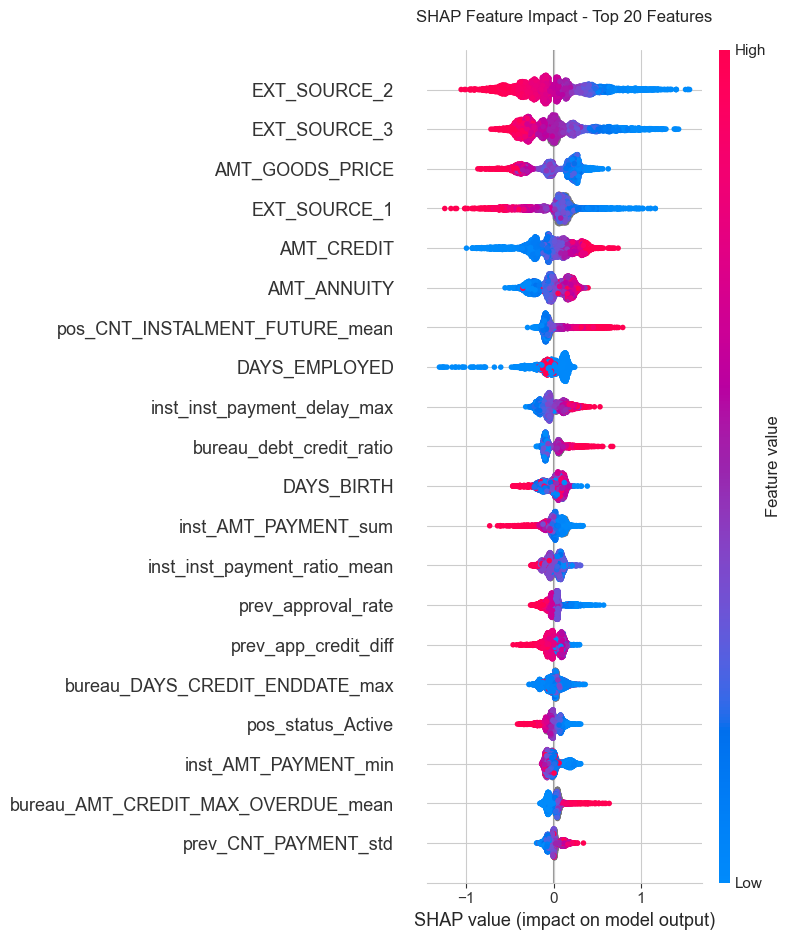

In [23]:
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_val_sample, max_display=20, show=False)
plt.title('SHAP Feature Impact - Top 20 Features', pad=20)
plt.tight_layout()
plt.show()


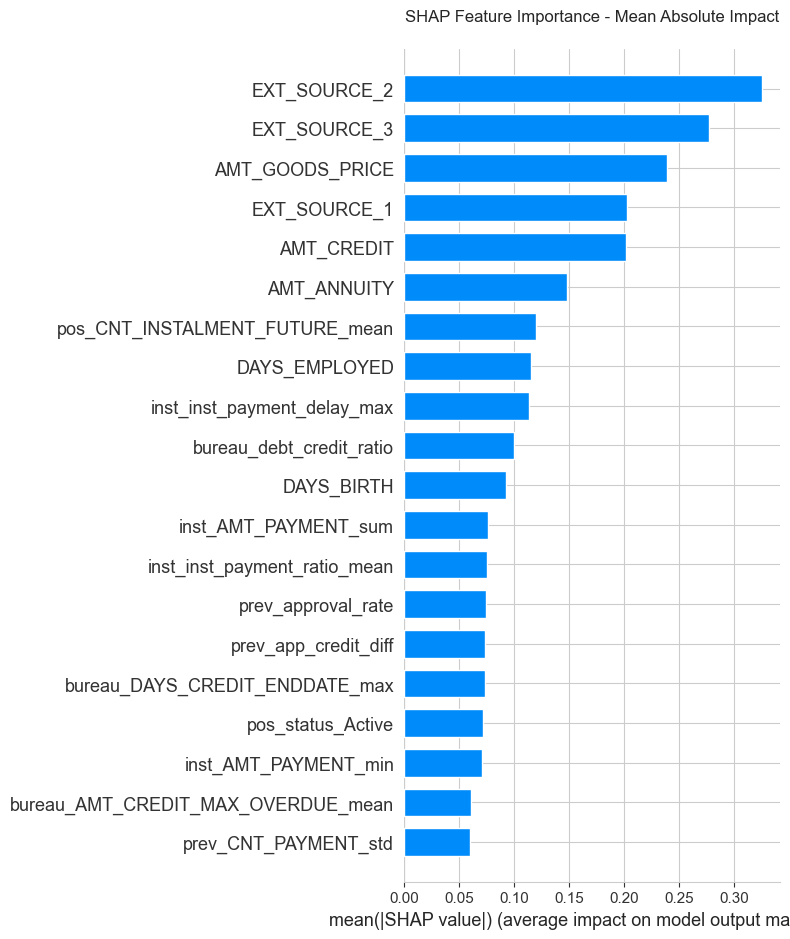

In [24]:
# SHAP Bar Plot - Mean absolute values
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_val_sample, plot_type='bar', max_display=20, show=False)
plt.title('SHAP Feature Importance - Mean Absolute Impact', pad=20)
plt.tight_layout()
plt.show()


### Final Features List

In [32]:
selected_features

['EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'EXT_SOURCE_2',
 'AMT_GOODS_PRICE',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'DAYS_EMPLOYED',
 'pos_CNT_INSTALMENT_FUTURE_mean',
 'inst_inst_payment_delay_max',
 'bureau_DAYS_CREDIT_max',
 'prev_app_credit_diff',
 'DAYS_ID_PUBLISH',
 'inst_AMT_PAYMENT_sum',
 'prev_approval_rate',
 'prev_HOUR_APPR_PROCESS_START_mean',
 'bureau_AMT_CREDIT_SUM_sum',
 'pos_CNT_INSTALMENT_FUTURE_min',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_LAST_PHONE_CHANGE',
 'prev_DAYS_DECISION_min',
 'bureau_AMT_CREDIT_MAX_OVERDUE_mean',
 'inst_AMT_PAYMENT_min',
 'prev_DAYS_DECISION_max',
 'AMT_INCOME_TOTAL',
 'bureau_AMT_CREDIT_SUM_max',
 'prev_CNT_PAYMENT_std',
 'inst_inst_payment_ratio_mean',
 'prev_AMT_GOODS_PRICE_max',
 'prev_AMT_ANNUITY_max',
 'bureau_DAYS_CREDIT_min',
 'inst_inst_payment_diff_mean',
 'bb_months_balance_size_mean',
 'bureau_debt_credit_ratio',
 'pos_status_Active',
 'prev_AMT_GOODS_PRICE_min',
 'inst_NU

### Decision Rules Extraction


In [39]:
print("TREE RULES")

def show_tree(model, tree_index=0):
    tree_dict = model.booster_.dump_model()['tree_info'][tree_index]
    
    def traverse(node, depth=0):
        indent = "  " * depth
        
        if 'split_feature' in node:
            # Split node
            feat = selected_features[node['split_feature']]
            thr = node['threshold']
            
            print(f"{indent}IF {feat} <= {thr:.2f}:")
            traverse(node['left_child'], depth+1)
            print(f"{indent}ELSE:")
            traverse(node['right_child'], depth+1)
        else:
            # Leaf
            val = node['leaf_value']
            print(f"{indent}→ {val:.4f}")
    
    print(f"\n--- Tree {tree_index} ---")
    traverse(tree_dict['tree_structure'])

# Show first 3 trees
for i in range(3):
    show_tree(final_model, i)

print(f"Total: {final_model.n_estimators} trees (showing first 3)")


TREE RULES

--- Tree 0 ---
IF EXT_SOURCE_3 <= 0.32:
  IF EXT_SOURCE_2 <= 0.36:
    IF EXT_SOURCE_3 <= 0.15:
      → -2.1771
    ELSE:
      → -2.2896
  ELSE:
    IF EXT_SOURCE_3 <= 0.13:
      → -2.3204
    ELSE:
      → -2.3955
ELSE:
  IF EXT_SOURCE_2 <= 0.39:
    IF EXT_SOURCE_3 <= 0.51:
      → -2.3627
    ELSE:
      → -2.4343
  ELSE:
    IF EXT_SOURCE_3 <= 0.50:
      → -2.4462
    ELSE:
      → -2.4767

--- Tree 1 ---
IF EXT_SOURCE_3 <= 0.32:
  IF EXT_SOURCE_2 <= 0.41:
    IF EXT_SOURCE_2 <= 0.08:
      → 0.2305
    ELSE:
      → 0.1148
  ELSE:
    IF bureau_debt_credit_ratio <= 0.50:
      → 0.0220
    ELSE:
      → 0.0736
ELSE:
  IF EXT_SOURCE_2 <= 0.31:
    IF EXT_SOURCE_3 <= 0.47:
      → 0.0789
    ELSE:
      → 0.0096
  ELSE:
    IF EXT_SOURCE_3 <= 0.50:
      → -0.0088
    ELSE:
      → -0.0408

--- Tree 2 ---
IF EXT_SOURCE_2 <= 0.41:
  IF EXT_SOURCE_3 <= 0.43:
    IF EXT_SOURCE_2 <= 0.13:
      → 0.1389
    ELSE:
      → 0.0604
  ELSE:
    IF EXT_SOURCE_2 <= 0.14:
      →